In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

from pprint import pprint
from math import floor

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
import matplotlib.cm as cm

from clickhouse_driver import Client

database = "spoofdb"
client = Client('localhost', database=database)

In [2]:
%%time 

exp_data_sql = """
SELECT
	ex.*,
	d.dnid,
	n.*
FROM
	experiment ex
	LEFT JOIN deployed_node d ON d.exp_id = ex.exp_id
	LEFT JOIN node n ON d.node_id = n.node_id
GROUP BY
	ex.exp_id,
	n.node_id,
	d.dnid
ORDER BY
	ex.attacker_rate,
	ex.num_proxy_connections
"""

exp_data_sql = """
SELECT
	ex.*,
	ndn.*
FROM
	experiment ex
	LEFT JOIN
		(SELECT * FROM deployed_node d 
		 LEFT JOIN node n ON d.node_id = n.node_id) ndn ON ndn.exp_id = ex.exp_id
ORDER BY
	ex.attacker_rate,
	ex.num_proxy_connections
"""

lay_of_the_land = client.query_dataframe(exp_data_sql)
print("\n".join(lay_of_the_land.exp_id.unique().tolist()))
print()
lay_of_the_land

TEST_gigabit_attack_without_spoof
TEST_gigabit_attack_with_spoof

CPU times: user 12.3 ms, sys: 0 ns, total: 12.3 ms
Wall time: 46.1 ms


,exp_id,attacker_rate,server_connections,max_keep_alive_requests,num_clients,num_trials,origin_server_duration,attacker_duration,receiver_duration,proxy_duration,...,run_proxy_with_dtls,run_proxy_with_https,run_attacker,dnid,ndn_exp_id,node_id,n_node_id,node_name,hardware_type,operating_system
0,TEST_gigabit_attack_without_spoof,1000mbps,256,0,1,1,120,20,120,120,...,False,False,True,6,TEST_gigabit_attack_without_spoof,1,1,attacker,microcloud,ubuntu1804-std
1,TEST_gigabit_attack_without_spoof,1000mbps,256,0,1,1,120,20,120,120,...,False,False,True,7,TEST_gigabit_attack_without_spoof,2,2,client1,microcloud,ubuntu1804-std
2,TEST_gigabit_attack_without_spoof,1000mbps,256,0,1,1,120,20,120,120,...,False,False,True,8,TEST_gigabit_attack_without_spoof,3,3,originserver,microcloud,ubuntu1804-std
3,TEST_gigabit_attack_without_spoof,1000mbps,256,0,1,1,120,20,120,120,...,False,False,True,9,TEST_gigabit_attack_without_spoof,4,4,proxy,microcloud,ubuntu1804-std
4,TEST_gigabit_attack_without_spoof,1000mbps,256,0,1,1,120,20,120,120,...,False,False,True,10,TEST_gigabit_attack_without_spoof,5,5,receiver,microcloud,ubuntu1804-std
5,TEST_gigabit_attack_with_spoof,1000mbps,256,0,1,1,120,20,120,120,...,False,False,True,1,TEST_gigabit_attack_with_spoof,1,1,attacker,microcloud,ubuntu1804-std
6,TEST_gigabit_attack_with_spoof,1000mbps,256,0,1,1,120,20,120,120,...,False,False,True,2,TEST_gigabit_attack_with_spoof,2,2,client1,microcloud,ubuntu1804-std
7,TEST_gigabit_attack_with_spoof,1000mbps,256,0,1,1,120,20,120,120,...,False,False,True,3,TEST_gigabit_attack_with_spoof,3,3,originserver,microcloud,ubuntu1804-std
8,TEST_gigabit_attack_with_spoof,1000mbps,256,0,1,1,120,20,120,120,...,False,False,True,4,TEST_gigabit_attack_with_spoof,4,4,proxy,microcloud,ubuntu1804-std
9,TEST_gigabit_attack_with_spoof,1000mbps,256,0,1,1,120,20,120,120,...,False,False,True,5,TEST_gigabit_attack_with_spoof,5,5,receiver,microcloud,ubuntu1804-std


In [3]:
%%time 

exp_id = "TEST_gigabit_attack_with_spoof"

df = lay_of_the_land
df = df[(df["exp_id"] == exp_id)]

exp_config = df.head(1).to_dict(orient="records")[0]
run_proxy_with_dtls = exp_config["run_proxy_with_dtls"]

records = df[["node_name", "dnid", "node_id"]].to_records(index=False)

node_map_node_id = dict()
node_map_dnid = dict()
client_node_ids = set()
client_dnids = set()
proxy_node_id = None
proxy_dnid = None
attacker_node_id = None
attacker_dnid = None
attacker_message_receiver_node_id = None
attacker_message_receiver_dnid = None
receiver_node_id = None
receiver_dnid = None

for node_name, dnid, node_id in records:
    node_map_node_id[node_name] = node_id
    node_map_dnid[node_name] = dnid
    if node_name.startswith("client"):
        client_node_ids.add(node_id)
        client_dnids.add(dnid)
    elif node_name == 'proxy':
        proxy_node_id = node_id
        proxy_dnid = dnid
    elif node_name == 'attacker':
        attacker_node_id = node_id
        attacker_dnid = dnid
    elif node_name == 'receiver':
        receiver_node_id = node_id
        receiver_dnid = dnid
    
dnid_map_node = {d:n for n,d in node_map_dnid.items()}
experiment_dnids = set(dnid_map_node.keys())

if not run_proxy_with_dtls:
  # The attacker regularly exploits IP address spoofing
  # to "purify" its attacking process by forcing all traffic
  # that it sent to go to the receiver
  attacker_message_receiver_node_id = receiver_node_id
  attacker_message_receiver_dnid = receiver_dnid
else:
  # Running with DTLS means the attacker receives
  # all the traffic it sent out, because there is
  # no spoofing with DTLS
  attacker_message_receiver_node_id = attacker_node_id
  attacker_message_receiver_dnid = attacker_dnid
    
print(f"{node_map_node_id=}")
print(f"{node_map_dnid=}")
print(f"{dnid_map_node=}")
print(f"{experiment_dnids=}")
print()
print(f"{client_node_ids=}")
print(f"{client_dnids=}")
print()
print(f"{attacker_message_receiver_node_id=}")
print(f"{attacker_message_receiver_dnid=}")
print()

exp_config

node_map_node_id={'attacker': 1, 'client1': 2, 'originserver': 3, 'proxy': 4, 'receiver': 5}
node_map_dnid={'attacker': 1, 'client1': 2, 'originserver': 3, 'proxy': 4, 'receiver': 5}
dnid_map_node={1: 'attacker', 2: 'client1', 3: 'originserver', 4: 'proxy', 5: 'receiver'}
experiment_dnids={1, 2, 3, 4, 5}

client_node_ids={2}
client_dnids={2}

attacker_message_receiver_node_id=5
attacker_message_receiver_dnid=5

CPU times: user 6.71 ms, sys: 3.35 ms, total: 10.1 ms
Wall time: 8.88 ms


{'exp_id': 'TEST_gigabit_attack_with_spoof',
 'attacker_rate': '1000mbps',
 'server_connections': 256,
 'max_keep_alive_requests': 0,
 'num_clients': 1,
 'num_trials': 1,
 'origin_server_duration': 120,
 'attacker_duration': 20,
 'receiver_duration': 120,
 'proxy_duration': 120,
 'client_duration': 100,
 'attacker_start_lag_duration': 20,
 'topology_name': 'cloud_proxy_and_internet_attacker',
 'num_proxy_connections': 50,
 'request_timeout': '5',
 'max_retries': 2,
 'keep_alive_duration': '5',
 'request_retry_interval': '1',
 'reuse_connections': True,
 'run_proxy_with_dtls': False,
 'run_proxy_with_https': False,
 'run_attacker': True,
 'dnid': 1,
 'ndn_exp_id': 'TEST_gigabit_attack_with_spoof',
 'node_id': 1,
 'n_node_id': 1,
 'node_name': 'attacker',
 'hardware_type': 'microcloud',
 'operating_system': 'ubuntu1804-std'}

In [4]:
%%time

summary_sql = f"""
SELECT 
	'{exp_id}' AS exp_id,
	e.observer_id,
	e.trial,
	COUNT (e.message_marker) AS total_messages,
	MIN(e.observe_timestamp) min_timestamp_sec,
	MAX(e.observe_timestamp) max_timestamp_sec,
	MAX(e.observe_timestamp) - MIN(e.observe_timestamp) active_time_sec,
	(SELECT ex.run_proxy_with_dtls FROM experiment ex WHERE ex.exp_id = '{exp_id}') AS run_proxy_with_dtls
FROM  
	event e
WHERE 
	e.observer_id IN ({','.join(map(str, experiment_dnids))})
GROUP BY
	e.observer_id, e.trial
"""

sdf = client.query_dataframe(summary_sql)
sdf.observer_id.replace(dnid_map_node, inplace=True)
sdf

CPU times: user 10 ms, sys: 2.39 ms, total: 12.4 ms
Wall time: 83.5 ms


,exp_id,observer_id,trial,total_messages,min_timestamp_sec,max_timestamp_sec,active_time_sec,run_proxy_with_dtls
0,TEST_gigabit_attack_with_spoof,receiver,1,397165,20.534625,45.360363,24.825738,False
1,TEST_gigabit_attack_with_spoof,client1,1,2759,0.000000,98.659161,98.659161,False
2,TEST_gigabit_attack_with_spoof,originserver,1,162384,0.148129,99.415416,99.267287,False
3,TEST_gigabit_attack_with_spoof,attacker,1,514870,20.551071,40.402104,19.851033,False
4,TEST_gigabit_attack_with_spoof,proxy,1,1079838,0.050495,99.423116,99.372621,False


<IPython.core.display.Javascript object>


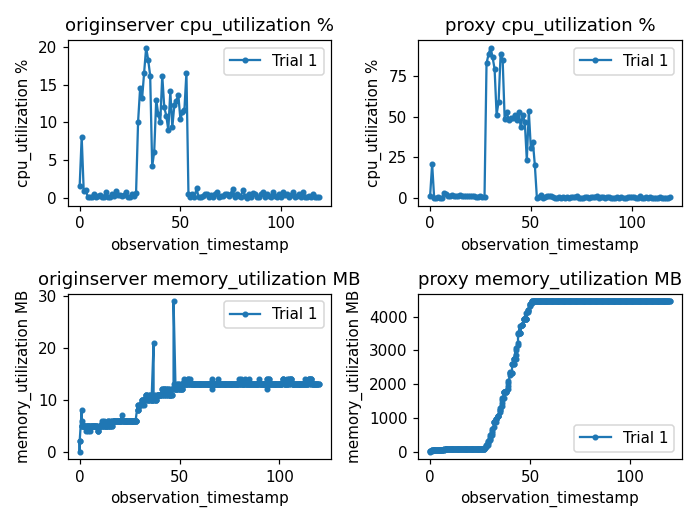

CPU times: user 485 ms, sys: 177 ms, total: 663 ms
Wall time: 335 ms


,observer_id,trial,observation_timestamp,metric_type,metric_value
0,originserver,1,0.0,cpu_utilization,2.0
1,originserver,1,0.0,memory_utilization,241.0
2,originserver,1,0.0,memory_utilization,239.0
3,originserver,1,0.0,memory_utilization,241.0
4,originserver,1,1.0,cpu_utilization,8.5
...,...,...,...,...,...
1268,proxy,1,119.0,memory_utilization,4693.0
1269,proxy,1,119.0,memory_utilization,4693.0
1270,proxy,1,119.0,memory_utilization,4693.0
1271,proxy,1,120.0,memory_utilization,4693.0


In [5]:
%%time

%matplotlib notebook

# Plot the node metrics for each device

metrics_sql = f"""
SELECT nm.*
FROM node_metric nm
WHERE nm.observer_id IN ({','.join(map(str, dnid_map_node.keys()))})
ORDER BY nm.observer_id, nm.trial, nm.observation_timestamp, nm.metric_type
"""

metrics_df = client.query_dataframe(metrics_sql)

metrics_df

# Replace dnids with human-readable node names
metrics_df.observer_id.replace(dnid_map_node, inplace=True)

metric_types = metrics_df.metric_type.unique()
node_names = metrics_df.observer_id.unique()
trials = metrics_df.trial.unique()

metric_type_map_extension = {
    "cpu_utilization": "%",
    "memory_utilization": "MB",
}

fig, axs = plt.subplots(len(node_names), len(metric_types))
for i, mt in enumerate(metric_types):
    for j, node_name in enumerate(node_names):
        for t in trials:
            # Filter each metric type observer node into its own tile, further filter by trial
            ax = axs[i, j]
            _df = metrics_df[(metrics_df["metric_type"] == mt) 
                             & (metrics_df["observer_id"] == node_name)
                             & (metrics_df["trial"] == t)]
            
            # Normalize the timestamp and metric value of the experiment
            _df["observation_timestamp"] -= min(_df["observation_timestamp"])
            _df["metric_value"] -= min(_df["metric_value"])
            
            _df.plot(kind="line", x="observation_timestamp", y="metric_value", marker=".", ax=ax, label=f"Trial {t}")

            ylabel = mt + " " + metric_type_map_extension[mt]
            ax.set_ylabel(ylabel)
            ax.set_title(node_name + " " + ylabel)

fig.tight_layout()
plt.show()

metrics_df

In [6]:
%%time

# Query without CTE
client_messages_sql = f"""
SELECT
'{exp_id}'AS exp_id,
es.trial AS trial,
es.observer_id AS observer_id,
es.message_marker AS message_marker,
MIN(es.observe_timestamp) AS send_time_sec,
MIN(er.observe_timestamp) AS recv_time_sec,
MIN(es.observe_timestamp) AS first_send_time_sec,
MAX(es.observe_timestamp) AS last_send_time_sec,
MIN(er.observe_timestamp) AS first_recv_time_sec,
MAX(er.observe_timestamp) AS last_recv_time_sec,
1e3 * (MIN(er.observe_timestamp) - MIN(es.observe_timestamp)) AS rtt_ms_first_transmission,
1e3 * (MIN(er.observe_timestamp) - MAX(es.observe_timestamp)) AS rtt_ms_last_transmission,
COUNT(es.observe_timestamp) AS num_send_observations,
COUNT(er.observe_timestamp) AS num_recv_observations,
SUM(CASE WHEN cms.coap_retransmitted = true THEN 1 ELSE 0 END) AS num_retransmissions
FROM event es
JOIN message ms ON ms.message_id = es.message_id
JOIN coap_message cms ON cms.cmci = ms.coap_message
JOIN event er ON er.trial = es.trial AND er.observer_id = es.observer_id AND er.message_marker = es.message_marker 
JOIN message mr ON mr.message_id = er.message_id
WHERE es.observer_id IN ({','.join(map(str, client_dnids))}) -- client dnids
    AND ms.src_id != {proxy_node_id} -- not proxy node_id
    AND er.observer_id IN ({','.join(map(str, client_dnids))}) -- client dnids
    AND mr.src_id == {proxy_node_id} -- proxy node_id
GROUP BY trial, observer_id, message_marker
ORDER BY trial, observer_id, message_marker
"""

# Query with CTE -- this is much faster for some reason (250ms vs 11sec)
client_messages_sql = f"""
WITH client_sends AS (
  SELECT
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_retransmitted AS coap_retransmitted
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))}) -- client dnids
    AND m.src_id != {proxy_node_id} -- not proxy node_id
), 

client_recvs AS (
  SELECT
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))}) -- client dnids
    AND m.src_id == {proxy_node_id} -- proxy node_id
)

SELECT
  '{exp_id}'AS exp_id,
  client_sends.trial AS trial,
  client_sends.observer_id AS observer_id,
  client_sends.message_marker AS message_marker,
  MIN(client_sends.observe_timestamp) AS send_time_sec,
  MIN(client_recvs.observe_timestamp) AS recv_time_sec,
  MIN(client_sends.observe_timestamp) AS first_send_time_sec,
  MAX(client_sends.observe_timestamp) AS last_send_time_sec,
  MIN(client_recvs.observe_timestamp) AS first_recv_time_sec,
  MAX(client_recvs.observe_timestamp) AS last_recv_time_sec,
  1e3 * (MIN(client_recvs.observe_timestamp) - MIN(client_sends.observe_timestamp)) AS rtt_ms_first_transmission,
  1e3 * (MIN(client_recvs.observe_timestamp) - MAX(client_sends.observe_timestamp)) AS rtt_ms_last_transmission,
  COUNT(client_sends.observe_timestamp) AS num_send_observations,
  COUNT(client_recvs.observe_timestamp) AS num_recv_observations,
  SUM(CASE WHEN client_sends.coap_retransmitted = true THEN 1 ELSE 0 END) AS num_retransmissions
FROM client_sends
  JOIN client_recvs USING (trial, observer_id, message_marker)
GROUP BY 
  trial, observer_id, message_marker
ORDER BY
  trial, observer_id, message_marker
"""

rtts_df = client.query_dataframe(client_messages_sql)
rtts_df.observer_id.replace(dnid_map_node, inplace=True)

# Compute RTT stats and merge into the df
stats_df = (
  rtts_df
  .groupby(by=["exp_id", "trial", "observer_id"])
  .agg(
    num_messages=("message_marker", pd.Series.nunique),
    global_first_send_time_sec=("send_time_sec", "min"),
    global_last_recv_time_sec=("recv_time_sec", "max"),
  )
  .reset_index()
)
stats_df["average_rps"] = stats_df["num_messages"] / (stats_df["global_last_recv_time_sec"] - stats_df["global_first_send_time_sec"])
rtts_df = rtts_df.merge(stats_df, on=["exp_id", "trial", "observer_id"])

rtts_df

CPU times: user 40.4 ms, sys: 2.72 ms, total: 43.1 ms
Wall time: 107 ms


,exp_id,trial,observer_id,message_marker,send_time_sec,recv_time_sec,first_send_time_sec,last_send_time_sec,first_recv_time_sec,last_recv_time_sec,rtt_ms_first_transmission,rtt_ms_last_transmission,num_send_observations,num_recv_observations,num_retransmissions,num_messages,global_first_send_time_sec,global_last_recv_time_sec,average_rps
0,TEST_gigabit_attack_with_spoof,1,client1,1,0.000000,0.204696,0.000000,0.000000,0.204696,0.204696,204.695940,204.695940,1,1,0,1377,0.0,98.658642,13.957216
1,TEST_gigabit_attack_with_spoof,1,client1,2,0.222177,0.279323,0.222177,0.222177,0.279323,0.279323,57.146072,57.146072,1,1,0,1377,0.0,98.658642,13.957216
2,TEST_gigabit_attack_with_spoof,1,client1,3,0.281784,0.338199,0.281784,0.281784,0.338199,0.338199,56.414843,56.414843,1,1,0,1377,0.0,98.658642,13.957216
3,TEST_gigabit_attack_with_spoof,1,client1,4,0.340422,0.396020,0.340422,0.340422,0.396020,0.396020,55.598021,55.598021,1,1,0,1377,0.0,98.658642,13.957216
4,TEST_gigabit_attack_with_spoof,1,client1,5,0.398487,0.453733,0.398487,0.398487,0.453733,0.453733,55.245876,55.245876,1,1,0,1377,0.0,98.658642,13.957216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1372,TEST_gigabit_attack_with_spoof,1,client1,516243,98.393903,98.446385,98.393903,98.393903,98.446385,98.446385,52.481890,52.481890,1,1,0,1377,0.0,98.658642,13.957216
1373,TEST_gigabit_attack_with_spoof,1,client1,516244,98.446931,98.499513,98.446931,98.446931,98.499513,98.499513,52.581787,52.581787,1,1,0,1377,0.0,98.658642,13.957216
1374,TEST_gigabit_attack_with_spoof,1,client1,516245,98.500066,98.552510,98.500066,98.500066,98.552510,98.552510,52.443981,52.443981,1,1,0,1377,0.0,98.658642,13.957216
1375,TEST_gigabit_attack_with_spoof,1,client1,516246,98.553042,98.605510,98.553042,98.553042,98.605510,98.605510,52.468061,52.468061,1,1,0,1377,0.0,98.658642,13.957216


<IPython.core.display.Javascript object>


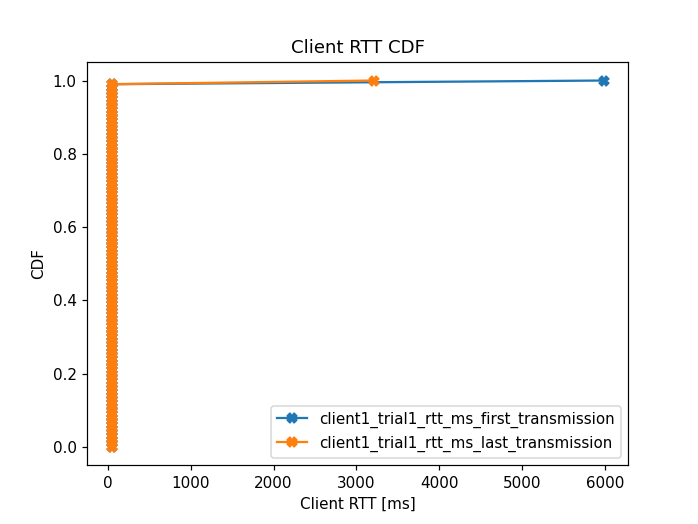

,percentile,trial,message_marker,send_time_sec,recv_time_sec,first_send_time_sec,last_send_time_sec,first_recv_time_sec,last_recv_time_sec,rtt_ms_first_transmission,rtt_ms_last_transmission,num_send_observations,num_recv_observations,num_retransmissions,num_messages,global_first_send_time_sec,global_last_recv_time_sec,average_rps
count,101.000000,101.0,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.0,101.0,101.000000,1.010000e+02
mean,0.500000,1.0,373235.511287,55.128095,55.218843,55.128095,55.140063,55.218843,55.218843,111.529905,84.079707,1.009901,1.009901,0.009901,1377.0,0.0,98.658642,1.395722e+01
std,0.293002,0.0,231300.216084,30.925429,30.885094,30.925429,30.912744,30.885094,30.885094,589.799300,313.928521,0.099504,0.099504,0.099504,0.0,0.0,0.000000,3.570433e-15
min,0.000000,1.0,1.000000,0.000000,0.204696,0.000000,0.000000,0.204696,0.204696,51.935911,51.935911,1.000000,1.000000,0.000000,1377.0,0.0,98.658642,1.395722e+01
25%,0.250000,1.0,345.000000,19.121955,19.175284,19.121955,19.121955,19.175284,19.175284,52.489996,52.489996,1.000000,1.000000,0.000000,1377.0,0.0,98.658642,1.395722e+01
50%,0.500000,1.0,515559.000000,61.986638,62.039051,61.986638,61.986638,62.039051,62.039051,52.563906,52.563906,1.000000,1.000000,0.000000,1377.0,0.0,98.658642,1.395722e+01
75%,0.750000,1.0,515903.000000,80.319407,80.371984,80.319407,80.319407,80.371984,80.371984,53.354025,53.354025,1.000000,1.000000,0.000000,1377.0,0.0,98.658642,1.395722e+01
max,1.000000,1.0,516247.000000,98.606103,98.658642,98.606103,98.606103,98.658642,98.658642,5980.248928,3207.778931,2.000000,2.000000,1.000000,1377.0,0.0,98.658642,1.395722e+01


In [7]:
plot_args = {
    "kind"  : "line",
    "y"     : "percentile",
    "marker": "X",
}

trials = rtts_df["trial"].unique()
clients = rtts_df["observer_id"].unique()
rtts = ["rtt_ms_first_transmission", "rtt_ms_last_transmission"]

ax = None
for t in trials:
  for c in clients:
    cdfdf = rtts_df[(rtts_df["trial"] == t) & (rtts_df["observer_id"] == c)]
    cdfdf = cdfdf.quantile(q=tuple(_q/100 for _q in range(0, 101, 1))).reset_index().rename(columns={"index":"percentile"})
    for rtt in rtts:
        label = f"{c}_trial{t}_{rtt}"
        ax = cdfdf.plot(x=rtt, label=label, ax = ax, **plot_args)

ax.set_ylabel("CDF")
ax.set_xlabel("Client RTT [ms]")
ax.set_title("Client RTT CDF")
plt.show()

cdfdf.describe()

<IPython.core.display.Javascript object>


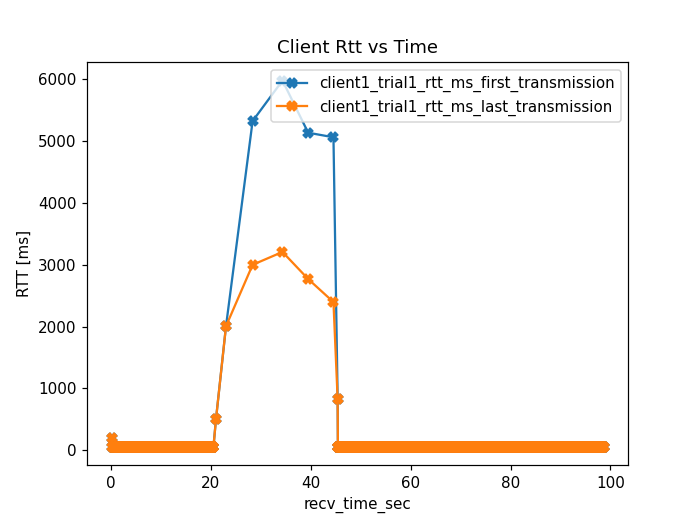

In [8]:
ignore_clients = {}
ignore_trials = {}

plot_args = {
    "kind"  : "line",
    "x"     : "recv_time_sec",
    "marker": "X",
}

# `trials`, `clients`, and `rtts` derived from above

ax = None
for t in trials:
    if t in ignore_trials:
        continue
        
    for c in clients:
        if c in ignore_clients:
            continue
            
        client_trial_df = rtts_df[(rtts_df["trial"] == t) & (rtts_df["observer_id"] == c)]
        
        for rtt in rtts:
          label = f"{c}_trial{t}_{rtt}"
          ax = client_trial_df.plot(label=label, y=rtt, **plot_args, ax=ax)

ax.set_title("Client Rtt vs Time")
ax.set_ylabel("RTT [ms]")
plt.show()

<IPython.core.display.Javascript object>


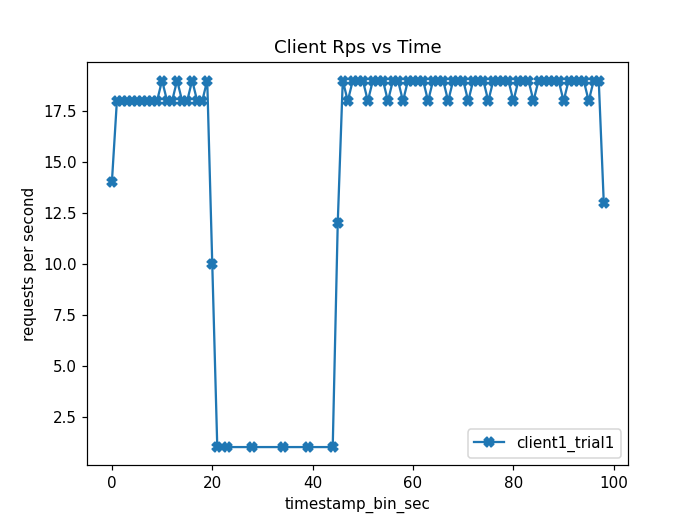

,timestamp_bin_sec,observer_id,packets_per_second
0,0.0,client1,14
1,1.0,client1,18
2,2.0,client1,18
3,3.0,client1,18
4,4.0,client1,18
...,...,...,...
76,94.0,client1,19
77,95.0,client1,18
78,96.0,client1,19
79,97.0,client1,19


In [9]:
ignore_clients = {}
ignore_trials = {}

plot_args = {
    "kind"  : "line",
    "x"     : "timestamp_bin_sec",
    "y"     : "packets_per_second",
    "marker": "X",
}

# `trials`, `clients`, and `rtts` derived from above

ax = None
for t in trials:
    if t in ignore_trials:
        continue
        
    trial_df = rtts_df[rtts_df["trial"] == t]
    trial_df["timestamp_bin_sec"] = np.floor(trial_df["recv_time_sec"])
    time_stats_df = trial_df.groupby(by=["timestamp_bin_sec", "observer_id"]).agg(\
                                             packets_per_second=("average_rps", "count")).reset_index()
    
    for c in clients:
        if c in ignore_clients:
            continue
            
        client_trial_df = time_stats_df[time_stats_df["observer_id"] == c]
        
        label = f"{c}_trial{t}"
        ax = client_trial_df.plot(label=label, ax=ax, **plot_args)

ax.set_title("Client Rps vs Time")
ax.set_ylabel("requests per second")
plt.show()

time_stats_df

<IPython.core.display.Javascript object>


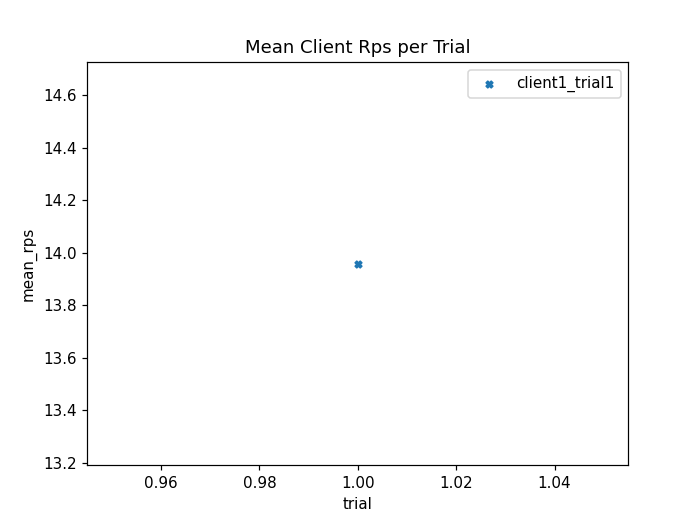

   trial   mean_rps
0      1  13.957216


,observer_id,trial,mean_rps
0,client1,1,13.957216


In [10]:
per_trial_stats_df = (
  rtts_df
  .groupby(by=["observer_id", "trial"])
  .agg(
    mean_rps=("average_rps", "mean")
  )
  .reset_index()
)

plot_args = {
    "kind"  : "scatter",
    "x"     : "trial",
    "y"     : "mean_rps",
    "marker": "X",
}

# `trials`, `clients`, and `rtts` derived from above

colors = iter([plt.cm.tab20(i) for i in range(20)])

ax = None
for t in trials:
    for c in clients:
        
        grouped_client_trial_df = per_trial_stats_df[(per_trial_stats_df["trial"] == t) & (per_trial_stats_df["observer_id"] == c)]
        
        label = "hi"
        label=f"{c}_trial{t}"
        ax = grouped_client_trial_df.plot(ax=ax, label=label, color=[next(colors)], **plot_args)
        
print(per_trial_stats_df.groupby(by=["trial"]).mean().reset_index()[["trial", "mean_rps"]])
       
ax.set_title("Mean Client Rps per Trial")
plt.show()

per_trial_stats_df

<IPython.core.display.Javascript object>


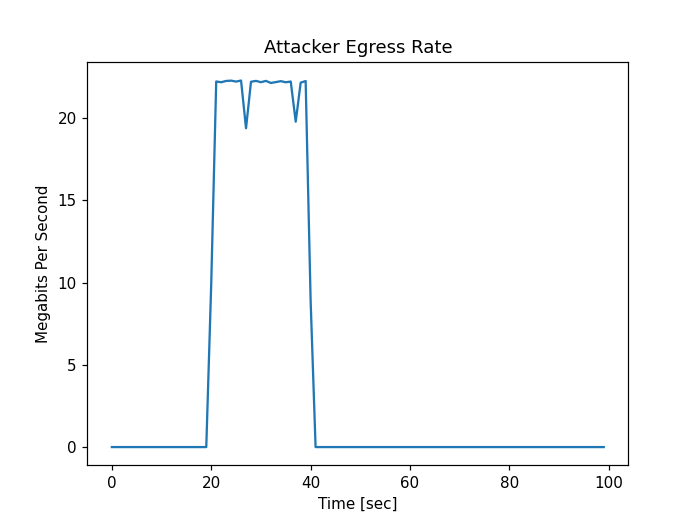

CPU times: user 1.72 s, sys: 550 ms, total: 2.27 s
Wall time: 2.33 s


,trial,timestamp_bin,sum_bytes,megabytes_per_second,megabits_per_second
0,1,0.0,0.0,0.0,0.0
0,1,1.0,0.0,0.0,0.0
0,1,2.0,0.0,0.0,0.0
0,1,3.0,0.0,0.0,0.0
0,1,4.0,0.0,0.0,0.0
...,...,...,...,...,...
0,1,95.0,0.0,0.0,0.0
0,1,96.0,0.0,0.0,0.0
0,1,97.0,0.0,0.0,0.0
0,1,98.0,0.0,0.0,0.0


In [11]:
%%time

attack_rate_sql = f"""
SELECT
'{exp_id}' AS exp_id,
{exp_config["client_duration"]} AS expected_client_duration,
e.trial AS trial,
e.message_marker AS message_marker,
e.message_id AS message_id,
e.observe_timestamp AS observe_timestamp,
m.size_bytes AS size_bytes,
cm.*
FROM
event e
JOIN message m ON m.message_id = e.message_id
JOIN coap_message cm ON cm.cmci = m.coap_message
WHERE
e.observer_id = {attacker_dnid} -- attacker dnid
AND m.dst_id = {proxy_node_id}  -- proxy node id
"""

ratedf = client.query_dataframe(attack_rate_sql)

ratedf["timestamp_bin"] = np.floor(ratedf["observe_timestamp"])
bins = list(range(max(ratedf["expected_client_duration"])))

tdf = ratedf.groupby(by=["trial", "timestamp_bin"]).agg(sum_bytes=('size_bytes', 'sum')).reset_index()

for trial in tdf.trial.unique():
    for missing_timestamp in set(bins) - set(tdf.timestamp_bin.unique()):
        _df = pd.DataFrame([[trial, missing_timestamp, 0.0]], columns=["trial", "timestamp_bin", "sum_bytes"])
        tdf = pd.concat([_df, tdf])

tdf.sort_values(by="timestamp_bin", inplace=True)
tdf["megabytes_per_second"] = 1e-6 * tdf["sum_bytes"]
tdf["megabits_per_second"] = 8 * tdf["megabytes_per_second"]

ax = tdf.plot(kind="line", x="timestamp_bin", y="megabits_per_second")
ax.set_title("Attacker Egress Rate")
ax.set_ylabel("Megabits Per Second")
ax.set_xlabel("Time [sec]")
ax.get_legend().remove()
plt.show()

tdf

In [12]:
%%time

# Without CTE: slow
attack_dbg_sql = f"""
SELECT
	dn.exp_id,
	e_attacker_send.trial,
	e_attacker_send.message_marker,
	(groupArray(cm_recv.coap_code))[1] AS coap_code,
	MIN(e_attacker_send.observe_timestamp) AS first_send_time_sec,
	1e3 * (MIN(e_proxy.observe_timestamp) - MIN(e_attacker_send.observe_timestamp)) AS attacker_to_proxy_ms,
	1e3 * (MAX(e_attacker_recv.observe_timestamp) - MIN(e_proxy.observe_timestamp)) AS proxy_to_attacker_ms,
	1e3 * (MAX(e_attacker_recv.observe_timestamp) - MIN(e_attacker_send.observe_timestamp)) AS attacker_to_receiver_rtt_ms,
	MIN(e_attacker_recv.observe_timestamp) AS first_recv_time_sec
FROM
	event e_attacker_send
	JOIN deployed_node dn
		ON dn.dnid = e_attacker_send.observer_id
	JOIN message m_e_attacker_send
		ON m_e_attacker_send.message_id = e_attacker_send.message_id
	JOIN event e_proxy
		ON  e_proxy.trial          = e_attacker_send.trial
		AND e_proxy.message_marker = e_attacker_send.message_marker
	JOIN event e_attacker_recv
		ON  e_attacker_recv.trial          = e_proxy.trial
		AND e_attacker_recv.message_marker = e_proxy.message_marker
		JOIN message m_e_attacker_recv
			ON m_e_attacker_recv.message_id = e_attacker_recv.message_id
			JOIN coap_message cm_recv 
				ON cm_recv.cmci = m_e_attacker_recv.coap_message
WHERE
	e_attacker_send.observer_id      = {attacker_dnid} -- Sending attacker observer: dnid
		AND m_e_attacker_send.dst_id = {proxy_node_id} -- Attacker sends to proxy: node_id
	AND e_proxy.observer_id          = {proxy_dnid} -- Proxy observer: dnid
	AND e_attacker_recv.observer_id  = {attacker_message_receiver_dnid} -- Receiving attacker observer: dnid
		AND m_e_attacker_recv.dst_id = {attacker_message_receiver_node_id} -- Receiving attacker destination is attacker: node_id
GROUP BY
	dn.exp_id,
	e_attacker_send.trial,
	e_attacker_send.message_marker
;
"""

# With CTE, fast
attack_dbg_sql = f"""
WITH e_attacker_send AS (
SELECT
e.observe_timestamp AS observe_timestamp,
e.trial AS trial,
e.message_marker AS message_marker
FROM event e
JOIN message m ON m.message_id = e.message_id
WHERE e.observer_id = {attacker_dnid} -- Sending attacker observer: dnid
AND m.dst_id = {proxy_node_id} -- Attacker sends to proxy: node_id
),

e_proxy AS (
SELECT
e.observe_timestamp AS observe_timestamp,
e.trial AS trial,
e.message_marker AS message_marker
FROM event e
WHERE e.observer_id = {proxy_dnid} -- Proxy observer: dnid
),

e_attacker_recv AS (
SELECT
e.observe_timestamp AS observe_timestamp,
e.trial AS trial,
e.message_marker AS message_marker,
cm.coap_code AS coap_code
FROM event e
JOIN message m ON m.message_id = e.message_id
JOIN coap_message cm ON cm.cmci = m.coap_message
WHERE e.observer_id = {attacker_message_receiver_dnid} -- Receiving attacker observer: dnid
AND m.dst_id = {attacker_message_receiver_node_id} -- Receiving attacker destination is attacker: node_id
)

SELECT
'{exp_id}' AS exp_id,
e_attacker_send.trial AS trial,
e_attacker_send.message_marker AS message_marker,
(groupArray(e_attacker_recv.coap_code))[1] AS coap_code,
MIN(e_attacker_send.observe_timestamp) AS first_send_time_sec,
abs(1e3 * (MIN(e_proxy.observe_timestamp) - MIN(e_attacker_send.observe_timestamp))) AS attacker_to_proxy_ms,
1e3 * (MAX(e_attacker_recv.observe_timestamp) - MIN(e_proxy.observe_timestamp)) AS proxy_to_attacker_ms,
1e3 * (MAX(e_attacker_recv.observe_timestamp) - MIN(e_attacker_send.observe_timestamp)) AS attacker_to_receiver_rtt_ms,
MIN(e_attacker_recv.observe_timestamp) AS first_recv_time_sec
FROM e_attacker_send
JOIN e_proxy ON e_proxy.trial = e_attacker_send.trial AND e_proxy.message_marker = e_attacker_send.message_marker
JOIN e_attacker_recv ON e_attacker_recv.trial = e_proxy.trial AND e_attacker_recv.message_marker = e_proxy.message_marker
GROUP BY e_attacker_send.trial, e_attacker_send.message_marker
ORDER BY first_send_time_sec
"""

print(attack_dbg_sql)

attack_dbg_df = client.query_dataframe(attack_dbg_sql)

attack_dbg_df


WITH e_attacker_send AS (
SELECT
e.observe_timestamp AS observe_timestamp,
e.trial AS trial,
e.message_marker AS message_marker
FROM event e
JOIN message m ON m.message_id = e.message_id
WHERE e.observer_id = 1 -- Sending attacker observer: dnid
AND m.dst_id = 4 -- Attacker sends to proxy: node_id
),

e_proxy AS (
SELECT
e.observe_timestamp AS observe_timestamp,
e.trial AS trial,
e.message_marker AS message_marker
FROM event e
WHERE e.observer_id = 4 -- Proxy observer: dnid
),

e_attacker_recv AS (
SELECT
e.observe_timestamp AS observe_timestamp,
e.trial AS trial,
e.message_marker AS message_marker,
cm.coap_code AS coap_code
FROM event e
JOIN message m ON m.message_id = e.message_id
JOIN coap_message cm ON cm.cmci = m.coap_message
WHERE e.observer_id = 5 -- Receiving attacker observer: dnid
AND m.dst_id = 5 -- Receiving attacker destination is attacker: node_id
)

SELECT
'TEST_gigabit_attack_with_spoof' AS exp_id,
e_attacker_send.trial AS trial,
e_attacker_send.message_marker AS messa

,exp_id,trial,message_marker,coap_code,first_send_time_sec,attacker_to_proxy_ms,proxy_to_attacker_ms,attacker_to_receiver_rtt_ms,first_recv_time_sec
0,TEST_gigabit_attack_with_spoof,1,371,content,20.551071,55.500031,91.630220,36.130190,20.587201
1,TEST_gigabit_attack_with_spoof,1,372,content,20.551074,55.488110,98.812103,43.323994,20.594398
2,TEST_gigabit_attack_with_spoof,1,373,content,20.551077,55.488110,98.790884,43.302774,20.594380
3,TEST_gigabit_attack_with_spoof,1,374,content,20.551079,55.488110,98.927021,43.438911,20.594518
4,TEST_gigabit_attack_with_spoof,1,375,content,20.551080,55.486917,62.737942,7.251024,20.558331
...,...,...,...,...,...,...,...,...,...
397160,TEST_gigabit_attack_with_spoof,1,515242,content,40.401914,55.806160,5014.253139,4958.446980,45.360361
397161,TEST_gigabit_attack_with_spoof,1,515243,content,40.401951,55.791140,5014.203072,4958.411932,45.360363
397162,TEST_gigabit_attack_with_spoof,1,515244,content,40.401989,55.737972,5014.106989,4958.369017,45.360358
397163,TEST_gigabit_attack_with_spoof,1,515245,content,40.402040,55.785894,5014.055014,4958.269119,45.360309


<IPython.core.display.Javascript object>


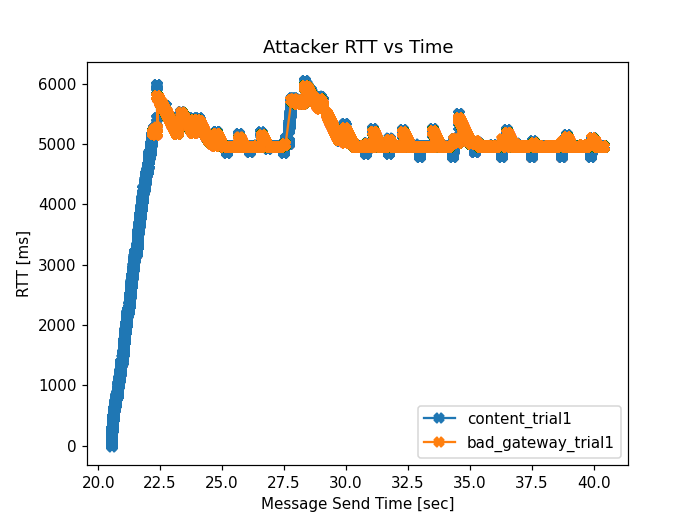

In [13]:
# Plot attacker rtt vs time

plot_args = {
  "kind": "line",
  "x": "first_send_time_sec",
  "y": "attacker_to_receiver_rtt_ms",
  "marker": "X",
}

coap_codes = attack_dbg_df["coap_code"].unique()
trials = attack_dbg_df["trial"].unique()

ax = None
for coap_code in coap_codes:
    if coap_code is None:
        continue
    for t in trials:
      _df = attack_dbg_df[(attack_dbg_df["coap_code"] == coap_code) & (attack_dbg_df["trial"] == t)]
      label = f"{coap_code}_trial{t}"
      ax = _df.plot(label=label, ax=ax, **plot_args)

ax.set_title("Attacker RTT vs Time")
ax.set_ylabel("RTT [ms]")
ax.set_xlabel("Message Send Time [sec]")
plt.show()

<IPython.core.display.Javascript object>


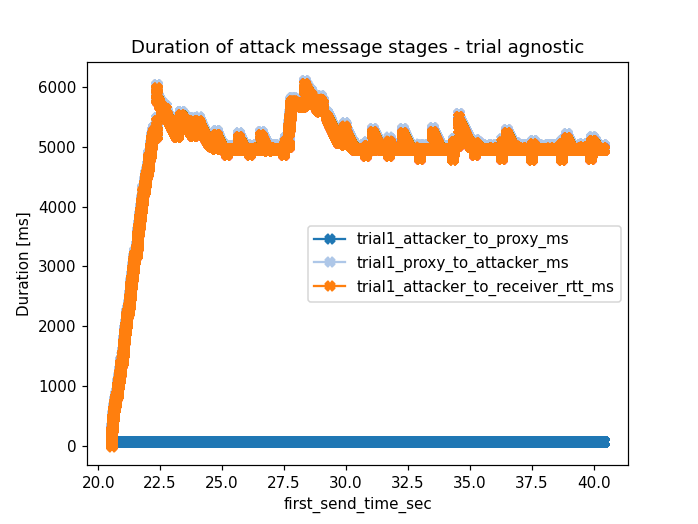

In [14]:
# Plot the duration of different stages of the attack messages

plot_args = {
  "kind": "line",
  "x": "first_send_time_sec",
  "marker": "X",
}

colors = iter([plt.cm.tab20(i) for i in range(20)])

rtts = ["attacker_to_proxy_ms", "proxy_to_attacker_ms", "attacker_to_receiver_rtt_ms"]

ax = None
for t in trials:
  for rtt in rtts:
    label = f"trial{t}_{rtt}"
    ax = attack_dbg_df.plot(y=rtt, ax=ax, label=label, color=[next(colors)], **plot_args)

ax.set_ylabel("Duration [ms]")
ax.set_title("Duration of attack message stages - trial agnostic")
ax.legend()

plt.show()